Frame 0 saved as C:/Users/Justin Joseph/OneDrive/Desktop/Project/ANPR/Plate_examples/chk\frame_0.jpg
Frame 50 saved as C:/Users/Justin Joseph/OneDrive/Desktop/Project/ANPR/Plate_examples/chk\frame_50.jpg
Frame 100 saved as C:/Users/Justin Joseph/OneDrive/Desktop/Project/ANPR/Plate_examples/chk\frame_100.jpg
Frame 150 saved as C:/Users/Justin Joseph/OneDrive/Desktop/Project/ANPR/Plate_examples/chk\frame_150.jpg
Frame 200 saved as C:/Users/Justin Joseph/OneDrive/Desktop/Project/ANPR/Plate_examples/chk\frame_200.jpg
Frame 250 saved as C:/Users/Justin Joseph/OneDrive/Desktop/Project/ANPR/Plate_examples/chk\frame_250.jpg
Frame 300 saved as C:/Users/Justin Joseph/OneDrive/Desktop/Project/ANPR/Plate_examples/chk\frame_300.jpg
Frame 350 saved as C:/Users/Justin Joseph/OneDrive/Desktop/Project/ANPR/Plate_examples/chk\frame_350.jpg
Frame 400 saved as C:/Users/Justin Joseph/OneDrive/Desktop/Project/ANPR/Plate_examples/chk\frame_400.jpg
9
1/1 [==============================] - 1s 1s/step


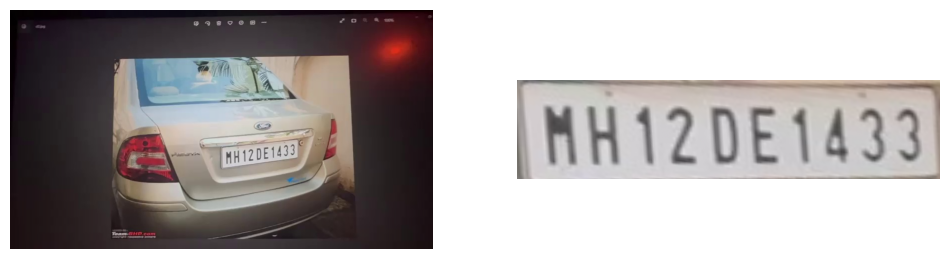

Detected 9 letters...
1/1 [==============================] - 0s 40ms/step
MH12DEA33
1/1 [==============================] - 1s 1s/step


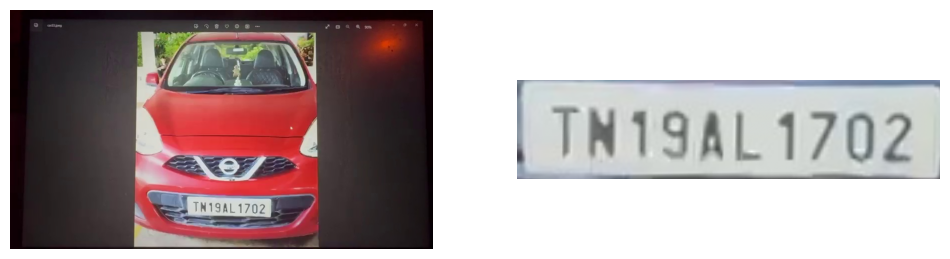

Detected 2 letters...
1/1 [==============================] - 0s 42ms/step
02
1/1 [==============================] - 1s 1s/step


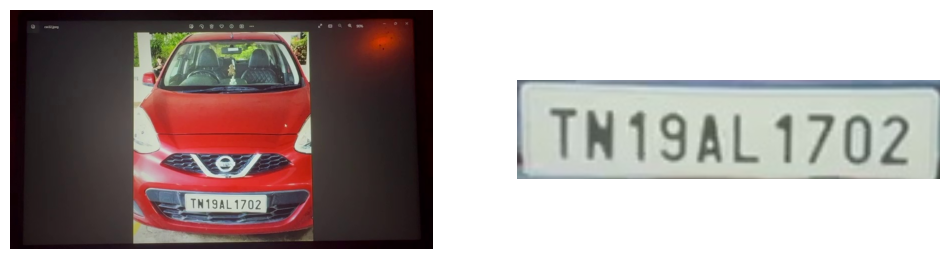

Detected 6 letters...
1/1 [==============================] - 0s 50ms/step
TM1702
1/1 [==============================] - 1s 1s/step


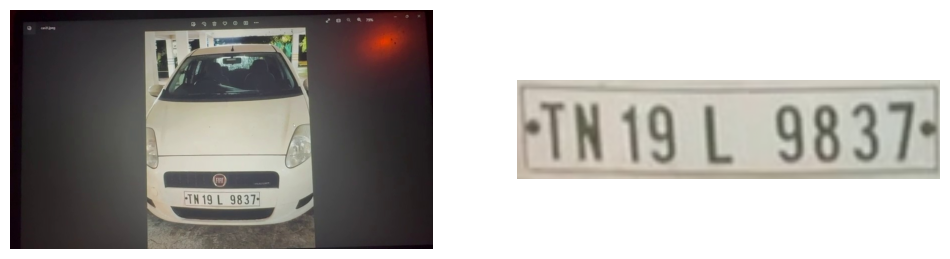

Detected 9 letters...
1/1 [==============================] - 0s 40ms/step
TN19L9837
1/1 [==============================] - 1s 1s/step


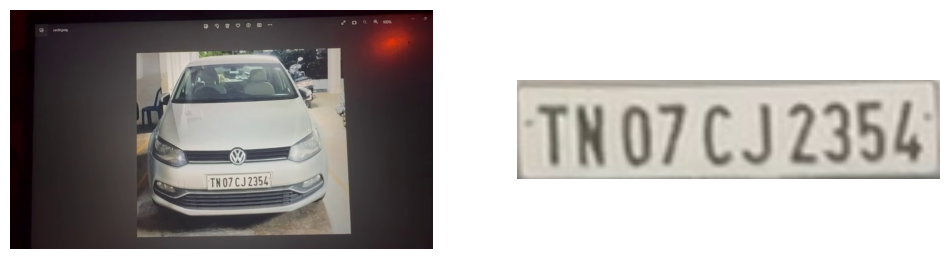

Detected 10 letters...
1/1 [==============================] - 0s 66ms/step
TN07CJ2354
1/1 [==============================] - 1s 1s/step


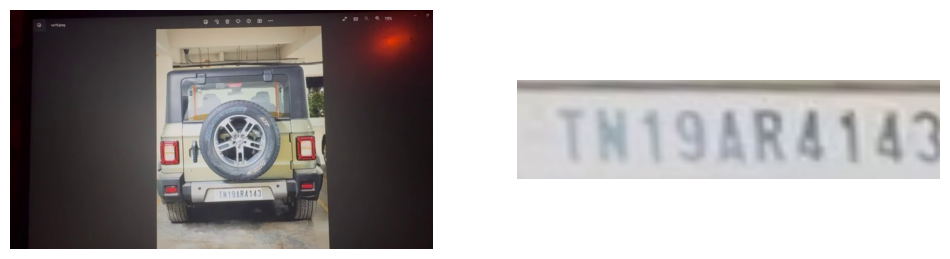

Detected 5 letters...
1/1 [==============================] - 0s 40ms/step
RA1A3
1/1 [==============================] - 1s 1s/step


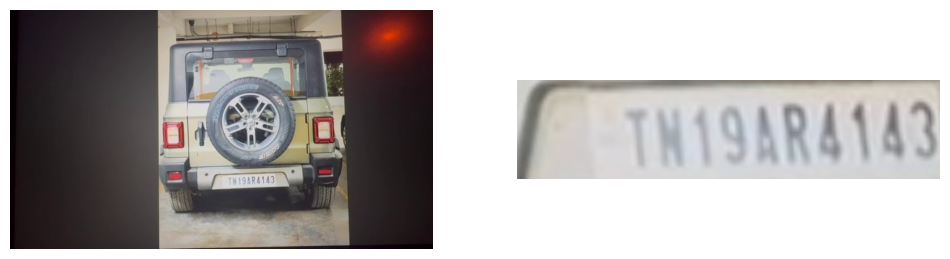

Detected 5 letters...
1/1 [==============================] - 0s 34ms/step
RA1A3
1/1 [==============================] - 1s 1s/step


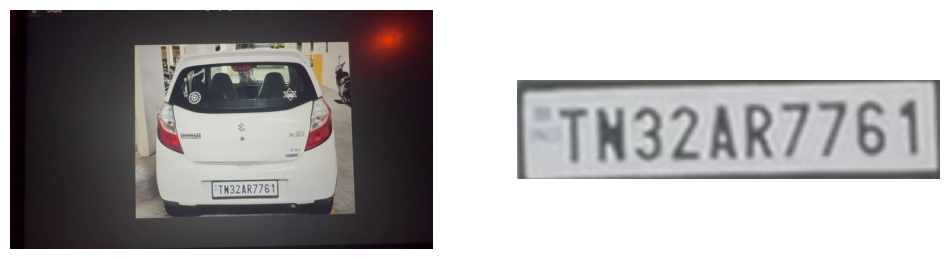

Detected 10 letters...
1/1 [==============================] - 0s 61ms/step
TN32AR7761
1/1 [==============================] - 1s 1s/step


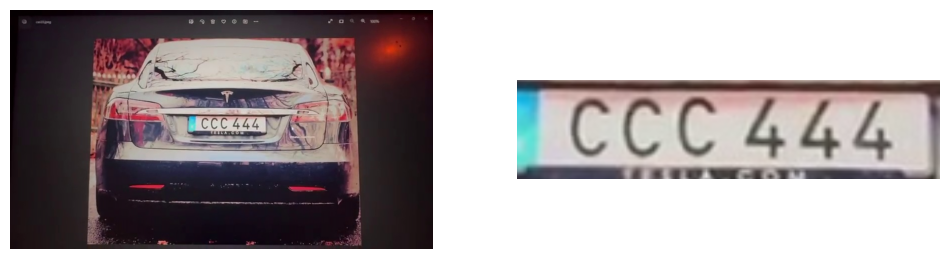

Detected 6 letters...
1/1 [==============================] - 0s 34ms/step
CCC444


In [2]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

def Lessgoo(imi_path):
    def load_model(path):
        try:
            path = splitext(path)[0]
            with open('%s.json' % path, 'r') as json_file:
                model_json = json_file.read()
            model = model_from_json(model_json, custom_objects={})
            model.load_weights('%s.h5' % path)
            #print("Loading model successfully...")
            return model
        except Exception as e:
            print(e)


    wpod_net_path = "wpod-net.json"
    wpod_net = load_model(wpod_net_path)

    image_path = imi_path

    # Replace with actual import
    def preprocess_image(image_path, resize=False):
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Error: Unable to load image from '{image_path}'")
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255
        if resize:
            img = cv2.resize(img, (224, 224))
        return img


    def get_plate(image_path, Dmax=608, Dmin=256):
        vehicle = preprocess_image(image_path)
        ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
        side = int(ratio * Dmin)
        bound_dim = min(side, Dmax)
        _, LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
        return vehicle, LpImg, cor

    test_image_path = image_path# Replace with the actual path to your image
    vehicle, LpImg, cor = get_plate(test_image_path)

    fig = plt.figure(figsize=(12, 6))
    grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    fig.add_subplot(grid[0])
    plt.axis(False)
    plt.imshow(vehicle)
    grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    fig.add_subplot(grid[1])
    plt.axis(False)
    plt.imshow(LpImg[0])
    plt.show()


    if (len(LpImg)): #check if there is at least one license image
        # Scales, calculates absolute values, and converts the result to 8-bit.
        plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
        
        # convert to grayscale and blur the image
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray,(7,7),0)
        
        # Applied inversed thresh_binary 
        binary = cv2.threshold(blur, 180, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        
        kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

        

    # Create sort_contours() function to grab the contour of each digit from left to right
    def sort_contours(cnts,reverse = False):
        i = 0
        boundingBoxes = [cv2.boundingRect(c) for c in cnts]
        (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                            key=lambda b: b[1][i], reverse=reverse))
        return cnts

    cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # creat a copy version "test_roi" of plat_image to draw bounding box
    test_roi = plate_image.copy()

    # Initialize a list which will be used to append charater image
    crop_characters = []

    # define standard width and height of character
    digit_w, digit_h = 30, 60

    for c in sort_contours(cont):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        if 1<=ratio<=3.5: # Only select contour with defined ratio
            if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
                # Draw bounding box arroung digit number
                cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

                # Sperate number and gibe prediction
                curr_num = thre_mor[y:y+h,x:x+w]
                curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
                _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                crop_characters.append(curr_num)

    print("Detected {} letters...".format(len(crop_characters)))
     

    # Load model architecture, weight and labels
    json_file = open('MobileNets_character_recognition.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights("License_character_recognition_weight.h5")
    #print("[INFO] Model loaded successfully...")

    labels = LabelEncoder()
    labels.classes_ = np.load('license_character_classes.npy')
    #print("[INFO] Labels loaded successfully...")


    # pre-processing input images and pedict with model
    def predict_from_model(image,model,labels):
        image = cv2.resize(image,(80,80))
        image = np.stack((image,)*3, axis=-1)
        prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
        return prediction


    final_string = ''
    for i,character in enumerate(crop_characters):
        title = np.array2string(predict_from_model(character,model,labels))
        final_string+=title.strip("'[]")

    print(final_string)
    



def capture_frames(video_path, output_directory, frame_interval=1):
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Initialize frame count
    frame_count = 0
    cn=0
    # Read the video frame by frame
    while True:
        ret, frame = cap.read()

        # Break the loop when no more frames are available
        if not ret:
            break

        # Save the frame if it's the desired interval frame
        if frame_count % frame_interval == 0:
            # Construct the filename for the saved frame
            filename = os.path.join(output_directory, f"frame_{frame_count}.jpg")

            # Save the frame as an image
            cv2.imwrite(filename, frame)
            cn+=1

            print(f"Frame {frame_count} saved as {filename}")

        # Increment the frame count
        frame_count += 1

    # Release the video capture object
    cap.release()

    print(cn)

# Example usage:
video_path = r'C:/Users/Justin Joseph/OneDrive/Desktop/Project/ANPR/Plate_examples/gg.mp4'
output_directory = r'C:/Users/Justin Joseph/OneDrive/Desktop/Project/ANPR/Plate_examples/chk'
capture_frames(video_path, output_directory, frame_interval=50)  # Adjust parameters as needed

import os

def list_image_paths(directory):
    image_paths = []
    for file_name in os.listdir(directory):
        if file_name.lower().endswith('.jpg') or file_name.lower().endswith('.jpeg'):
            image_paths.append(os.path.join(directory, file_name))
    return image_paths


def main():
    directory = 'C:/Users/Justin Joseph/OneDrive/Desktop/Project/ANPR/Plate_examples/chk'  # Replace this with the path to your directory
    image_paths = list_image_paths(directory)
    for image_path in image_paths:
        Lessgoo(image_path)

if __name__ == "__main__":
    main()


